In [2]:
import os
import sys
import math
from liblibra_core import * 
from libra_py import *
import numpy as np
import cProfile, pstats, io
import matplotlib.pyplot as plt
from scipy.special import gamma

In [3]:
# Profiles the code when MIW_Forces is run. Decorator needs to be turned on then ipynb -> py should work if needed in other files.
def profiler(func):
    # Decorater to profile the code, use for development
    def wrapper(*args, **kwargs):
        pr = cProfile.Profile()
        pr.enable()
        retval = func(*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        return(retval)
    return(wrapper)

#@profiler # Turn on/off decorator for profiling
def MIW_Forces(X, params, P = 0, Rsq = 0, Pi = 0, dPijk = 0, ddPijk = 0, dPik = 0, ddPik = 0, gik = 0):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        params: Dictionary with simulation parameters
        OPTIONAL: Include matrices of correct shape for force computation *Avoids ~10 allocs per MD step*
    Returns:
        F: Numpy array of with dimenions of X.shape. Can be added to the classical forces in Nuclear object.f prior to propagation.
        U: MIW Potential (**Without the kernel correction Eq.14 in Sturniolo 2018)
    """
    # D is dimensionality of space, J is number of particles per world, N is number of worlds.
    # b is kernel width parameter, and ktype is the type of kernel (exp or gaussian for now)
    # M is the matrix of size X.shape containing masses for the particles at the relevant entry M[i][k]
    # Notation in all functions consistent with 10.1103/PhysRevE.97.053311 and 10.1103/PhysRevX.4.041013
    N = len(X) 
    b = params["b"]
    D = params["D"]
    J = params["J"]
    M = params["M"]
    ktype = params["ktype"]
    
    # After profiling, just redoing the allocations is faster than passing the objects for small systems.
    if type(P) == int:
        # Initializes all needed multidims with correct shape
        # i/j loop over worlds i.e 1->N in conventional sense
        # k loops over coords i.e. 1->J*D in conventional sense
        Rsq   = np.zeros( (N, N) )
        P     = np.zeros( (N, N) )
        F     = np.zeros( (N, J*D) )
        Pi    = np.zeros( (N) )
        dPijk = np.zeros( (N, N, J*D) )
        dPik  = np.zeros( (N, J*D) )
        ddPijk= np.zeros( (N, N, J*D) )
        ddPik = np.zeros( (N, J*D) )
        gik   = np.zeros( (N, J*D) )

        
    #Compute Rsq matrix
    Rsq = Compute_Rsquared(X, Rsq)

    #Populate P matrix for P[i][j]
    P = Compute_P(X, Rsq, ktype, b, D, P = P)

    #Populate Pi matrix for Pi[i]
    for i in range(N):
        Pi[i] = Compute_Pi(X, P, i)


    #3 index terms computed together to minimize python looping
    #Populate dPijk matrix for dPijk[i][j][k]
    #Populate ddPijk matrix for ddPijk[i][j][k]
    for i in range(N):
        for k in range(J*D):
            for j in range(N):
                dPijk[i][j][k]  = Compute_dPijk(X, Rsq, i, j, k, b, P, ktype)
                ddPijk[i][j][k] = Compute_ddPijk(X, Rsq, i, j, k, b, P, ktype)

                #2 index terms computed in this same loop to minimize python loops further
                #Populate dPik matrix for dPik[i][k]
                #Populate ddPik matrix for ddPik[i][k]
                if j == range(N)[-1]:
                    #Works because for given i, k, once last j is filled out, 
                    #Pijk holds all j values for a given i, k
                    dPik[i][k]  = Compute_dPik(X, i, k, b, dPijk, ktype)
                    ddPik[i][k] = Compute_ddPik(X, i, k, b, ddPijk, ktype)
                    gik[i][k]   = Compute_gik(X, i, k, b, dPik, Pi, ktype) 
    
    
    # Currently most naive implementation is used for ease of troubleshooting.
    # The forces as is contain one loop for each summation in Eq A6, A9 in Sturniolo 2018
    if ktype.lower() == "gaussian":  
        
        # 1D simplification.
        if D == 1:
            # print("Using simplified forces for D = 1")
            for n in range(N):
                for l in range(J*D):
                    F[n][l] = -1 * ( ( 2 * gik[n][l] * ( -( 1.0/(Pi[n]**2) ) * dPik[n][l]**2 + ( 1.0/Pi[n] ) * ddPik[n][l] ) ) )

                    for i in range(N):
                        if i != n:
                            F[n][l] += -1 * 2 * gik[i][l] * ( ( 1.0/(Pi[i]**2) ) * dPijk[i][n][l]*dPik[i][l] 
                                                       - ( 1.0/Pi[i] ) * ddPijk[i][n][l] )
        # General case for D != 1                    
        else:
            
            #Eq A6 Sturniolo
            for n in range(N):
                for l in range(J*D):
                    F[n][l] = -1 * ( ( 2 * gik[n][l] * ( -( 1.0/(Pi[n]**2) ) * dPik[n][l]**2 + ( 1.0/Pi[n] ) * ddPik[n][l] ) ) )

                    for i in range(N):
                        if i != n:
                            F[n][l] += -1 * 2 * gik[i][l] * ( ( 1.0/(Pi[i]**2) ) * dPijk[i][n][l]*dPik[i][l] 
                                                       - ( 1.0/Pi[i] ) * ddPijk[i][n][l] )
                    for k in range(J*D):
                        if k != l:
                            res = 0
                            for j in range(N):
                                res += ( X[n][k]-X[j][k] ) * dPijk[n][j][l]

                            F[n][l] += -1 * 2 * gik[n][k] * ( -( 1.0/(Pi[n]**2) ) * dPik[n][k]*dPik[n][l] 
                                                            - 2.0/( b**2 * Pi[n] ) * res ) 

                    for i in range(N):
                        if i != n:
                            for k in range(J*D):
                                if k != l:
                                    F[n][l] += -1 * 2 * gik[i][k] * ( ( 1.0/(Pi[i]**2) ) * dPijk[i][n][k] * dPik[i][l]
                                                                    + ( 2.0/(b**2 * Pi[i]) ) * ( X[i][k] - X[n][k] ) * dPijk[i][n][l] )  

    elif ktype.lower() == "exponential": 
        
        #Eq A9 Sturniolo
        for n in range(N):
            for l in range(J*D):
                #Compute dU/dx_n^l
                F[n][l] += -1 * 2*gik[n][l]*( - ( 1/Pi[n]**2 ) * dPik[n][l]**2 + (1/Pi[n]) * ddPik[n][l] )
                
                for i in range(N):
                    if i != n:
                        F[n][l] += -1 * 2*gik[i][l]*( ( 1/Pi[i]**2 ) * dPijk[i][n][l] * dPik[i][l] - ( 1/Pi[i] ) * ddPijk[i][n][l] )
                for k in range(J*D):
                    if k != l:
                        res = 0
                        for j in range(N):
                            res += ( ( X[n][k]-X[j][k] ) / np.sqrt(Rsq[n][j]) ) * ( ( 1.0/np.sqrt(Rsq[n][j]) ) + ( 1.0/b ) ) * dPijk[n][j][l]             
                                                                         
                        F[n][l] += -1 * 2*gik[n][k]*( -( 1/Pi[n]**2 )  * dPik[n][k] * dPik[n][l] - ( 1/Pi[n] ) * res )
                for i in range(N):
                    if i != n:
                        for k in range(J*D):
                            if k != l:
                                F[n][l] += -1 * 2*gik[i][k]*( ( 1/Pi[i]**2 ) * dPijk[i][n][k] * dPik[i][l] + ( 1/Pi[i] ) * ( ( X[i][k]-X[n][k] )/np.sqrt(Rsq[i][n]) ) * ( ( 1/np.sqrt(Rsq[i][n]) ) + ( 1/b ) ) * dPijk[i][n][l] )
    
    U = Compute_MIW_Potential(X, b, gik, M, ktype)  
    print("Rsq[i][j]", Rsq[1][0])
    print("ddPik[1][1] = ", ddPik[1][1])
    print("Pij[0][1]", P[0][1])
    return(F, U)

# Matrix elements in Eq A1
def Compute_Rsquared(X, Rsq = 0):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        OPTIONAL Rsquared: Pass the last step's Rsquared matrix to avoid allocation cost at every step.
    Returns:
        Rsq: Matrix containing elements r_ij^2. Sum of squared distances of all componenents in the two worlds.
    """
    if type(Rsq) == int:
        Rsq = np.zeros((len(X), len(X)))
    else:
        pass
    
    for i in range(len(Rsq)):
        for j in range(len(Rsq[0])):
            Rsq[i][j] = np.inner(X[i]-X[j], X[i]-X[j])
    return(Rsq)

# Matrix elements in Eq A1
def  Compute_P(X, Rsq, ktype, b, D, P = 0):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        Rsq: Matrix containing elements r_ij^2. Sum of squared distances of all componenents in the two worlds.
        OPTIONAL, P: Passes P from last step to avoid reallocations at every dynamics step.
        ktype: Type of kernel being used, exponential or gaussian
    Returns:
        Rsq: Matrix containing elements r_ij^2. Sum of squared distances of all componenents in the two worlds.
    """
    if type(P) == int:
        P = np.zeros((len(X), len(X)))

    if ktype.lower() == 'gaussian':    
        for i in range(len(P)):
            for j in range(len(P)):
                P[i][j] = Compute_Pij(X, i, j, Rsq, b, D, ktype)
                
    # This is unnecessary since ktype is passed, but I'm just leaving it in for now
    # in case I separated these for some reason not immediately clear.
    elif ktype.lower() == 'exponential':
        for i in range(len(P)):
            for j in range(len(P)):
                P[i][j] = Compute_Pij(X, i, j, Rsq, b, D, ktype)
                
    
    return(P)
    
# Eq A1/A7 (Gaussian/Exponential)
def Compute_Pij(X, i, j, Rsq, b, D, ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        i: Index of the world being computed for
        j: Index to be summed over in computation of P_i
        b: Kernel width parameter
        D: Dimensionality of the space (used in cofactors)
        ktype: Kernel type ("gaussian" or "exponential")
        rijsquared: Sum of squared distances between coords of worlds i, j, $r_{ij}^2 = \Sigma_{k}( r_{ij}^k )^2$
    Returns:
        Pij: Density contribution of particle j at the position of particle i (Used for forces)
    """
    N = len(X)
    # Gaussian Kernel Computation
    
    if ktype.lower() == "gaussian":
        return ( 1 / ( N * ( np.sqrt(np.pi) * b )**D )  ) * np.exp( - Rsq[i][j] / (b**2) )
    elif ktype.lower() == "exponential":
        return ( ( gamma(D/2) / ( 2*N * math.factorial(D-1) * (np.sqrt(np.pi) * b )**D )  ) * np.exp(- np.sqrt(Rsq[i][j]) / b )  )
    

# Eq A2
def Compute_Pi(X, P, i):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        P: Promputed matrix with elements computed by Compute_Pij() function. P[i][j] = Compute_Pij(X, i, j, ...)
        i: Index of the world being computed for
    Returns:
        Pi: $\Sigma_{j} P_{ij}$
    """
    N = len(X)
    res = 0
    
    for j in range(N):
        res+= P[i][j]
        
    return(res)
        
# Gaussian follows from A1, Exponential in A7
def Compute_dPijk(X, Rsq, i, j, k, b, P,  ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        Rsq: Matrix with Rsq[i][j] standard inner product of (X[i][j], X[i][j])
        i: Index of the world being computed for
        j: Index to be summed over in computation of dP_i
        b: Kernel width parameter
        P: Matrix with elements Pij. Precomputed due to their usage in all derivatives.
        ktype: Kernel type ("gaussian" or "exponential")
        Pij: Value for Pij precomputed and stored in the P matrix. Pij = P[i][j]
    """
    
    rij_k = (X[i][k] - X[j][k])
    
    if ktype.lower() == "gaussian":
        return( -(2.0/b**2) * rij_k * P[i][j] )
    elif ktype.lower() == "exponential":
        if i != j:
            return (  -1/b * ( rij_k / np.sqrt(Rsq[i][j]) ) * P[i][j]  ) 
        else:
            return ( 0.0 ) 
    else:
        return("Error, kernel type not yet implemented.")
    
# ktype is not needed in these functions summed over j, will remove.
def Compute_dPik(X, i, k, b, dPijk, ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        i: Index of the world being computed for
        k: Component within the worlds being computed for.
        b: Kernel width parameter
        P: Matrix with elements Pij. Precomputed due to their usage in all derivatives.
        ktype: Kernel type ("gaussian" or "exponential") 
    Returns:
        res: dP_i^k, Sum over worlds j, of dPijk. Needed for force computation.
    """
    res = 0
    for j in range(len(X)):      
        res += dPijk[i][j][k]

    return(res)

# Eq A1 for Gaussian, Eq A7 for Exponential (upper index on LHS missing in paper I believe)
# Modification to the eq. in the paper necessary for exponential kernel detailed below.
def Compute_ddPijk(X, Rsq, i, j, k, b, P, ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        Rsq: Matrix with Rsq[i][j] standard inner product of (X[i][j], X[i][j])
        i: Index of the world being computed for
        j: Index to be summed over in ddP_i
        k: Component within the worlds being computed for.
        b: Kernel width parameter
        P: Matrix with elements Pij. Precomputed due to their usage in all derivatives.
        ktype: Kernel type ("gaussian" or "exponential")
    Returns:
        res: ddP_ij^k. Needed for force computations.
    """
    rij_k = X[i][k] - X[j][k]
    
    if ktype.lower() == "gaussian":
        # Test line
        # return( -2.0/(b**2) * ( 1 - (2.0/(b**2)) * np.sqrt(Rsq[i][j]) ) * P[i][j] )
        
        return( -2.0/(b**2) * ( 1 - (2.0/(b**2)) * rij_k**2 ) * P[i][j] )
        
    elif ktype.lower() == "exponential":
        
        # ***This is not mentioned in the paper but diagonal elements here will cause div by 0. For that reason, 
        # diagonal elements are set to be 0, however formally this is not stated to be the case from the equation (A7).
        if i != j:
            return( -1/(np.sqrt(Rsq[i][j]) * b) * ( 1.0 - (rij_k**2)/Rsq[i][j] - (1.0/b) * (rij_k**2)/np.sqrt(Rsq[i][j]) ) * P[i][j] ) 
        else:
            return ( 0 )

# Will remove ktype.
def Compute_ddPik(X, i, k, b, ddPijk, ktype):
    res = 0
    for j in range(len(X)):
        res += ddPijk[i][j][k]
    
    return(res)

# Eq A5
def Compute_gik(X, i, k, b, dPik, Pi, ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        i: Index of the world being computed for
        k: Component within the worlds being computed for.
        b: Kernel width parameter
        dPik: Matrix with dPik[i][k] elements for gik[i][k] computation
        Pi: Matrix with Pi[i] elements for gik[i][k] computation
        ktype: Kernel type ("gaussian" or "exponential")
    Returns:
        gik[i][k] value needed for computation of MIW forces and potential
    """
    return( .5 * dPik[i][k] / Pi[i] )

# Eq A5
# This specific function is for use within force computation (where gik is precomputed)
def Compute_MIW_Potential(X, b, gik, M, ktype):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        b: Kernel width parameter
        gik: Matrix containing gik elements as gik[i][k] **If not passed, will be computed using X.
        Mik: Matrix containing mass for the particle corresponding to X[i][k] as Mik[i][k]
        ktype: Kernel type ("gaussian" or "exponential")
    Returns:
        U: Scalar potential for the MIW potential U(X) ***Same as Compute_MIW_Potential2***
    """
    res = 0
    for i in range(len(X)):
        for k in range(len(X[0])):
            res += .5 * 1/M[i][k] * gik[i][k] ** 2
    return(res)


# Eq A5
# This function is for use where gik is not precomputed, i.e. for finite difference approach.
def Compute_MIW_Potential2(X, params):
    """
    Args:
        X: Numpy array containing arrays of N world configurations. N x JD dimensions.
        params: Dictionary with simulation parameters
    Returns:
        U: Scalar potential for the MIW potential U(X) ***Same as Compute_MIW_Potential***
    """
    N = len(X) 
    b = params["b"]
    D = params["D"]
    J = params["J"]
    M = params["M"]
    ktype = params["ktype"]

    # Initializes all needed multidims with correct shape
    # i/j loop over worlds i.e 1->N in conventional sense
    # k loops over coords i.e. 1->J*D in conventional sense
    Rsq   = np.zeros( (N, N) )
    P     = np.zeros( (N, N) )
    F     = np.zeros( (N, J*D) )
    Pi    = np.zeros( (N) )
    dPijk = np.zeros( (N, N, J*D) )
    dPik  = np.zeros( (N, J*D) )
    ddPijk= np.zeros( (N, N, J*D) )
    ddPik = np.zeros( (N, J*D) )
    gik   = np.zeros( (N, J*D) )

        
    #Compute Rsq matrix
    Rsq = Compute_Rsquared(X, Rsq)

    #Populate P matrix for P[i][j]
    P = Compute_P(X, Rsq, ktype, b, D, P=P)

    #Populate Pi matrix for Pi[i]
    for i in range(N):
        Pi[i] = Compute_Pi(X, P, i)
    for i in range(N):
        for k in range(J*D):
            for j in range(N):
                dPijk[i][j][k]  = Compute_dPijk(X, Rsq, i, j, k, b, P, ktype)
                ddPijk[i][j][k] = Compute_ddPijk(X, Rsq, i, j, k, b, P, ktype)

                #2 index terms computed in this same loop to minimize python loops further
                #Populate dPik matrix for dPik[i][k]
                #Populate ddPik matrix for ddPik[i][k]
                if j == range(N)[-1]:
                    #Works because for given i, k, once last j is filled out, 
                    #Pijk holds all j values for a given i, k
                    dPik[i][k]  = Compute_dPik(X, i, k, b, dPijk, ktype)
                    ddPik[i][k] = Compute_ddPik(X, i, k, b, ddPijk, ktype)
                    gik[i][k]   = Compute_gik(X, i, k, b, dPik, Pi, ktype)
    res = 0
    for i in range(len(X)):
        for k in range(len(X[0])):
            res += .5 * 1/M[i][k] * gik[i][k] ** 2
    return(res)

# **Function to be moved out of this file
# Populates simple 1D system with N worlds uniformly spaced
def Populate1DUniform(N, spacing):
    X = np.zeros((N, 1))
    for i in range(N):
        X[i][0] = -(N-1)/2.0 * spacing + i*spacing
    return(X)

# **Function to be moved out of this file
# Gives X uniformly sampled from [-boxmax, boxmax] in all 3 dimensions.
def Populate3DRandom(N, particles, boxmax):
    """
    Args:
        N: Number of worlds
        particles: Number of particles per work
        boxmax: max distance from origin along all dimensions for uniform sampling
    Returns:
        X: Uniformly sampled from [-boxmax, boxmax] in all 3 dimensions.
    """
    X = np.random.rand(N, 3*particles)
    X -= .5
    X *= boxmax*2
    return(X)

# Used for writing current configuration to an .xyz file in the scenario that the Libra objects were not initialized
# Basically just syst.print_xyz in case a system object wasn't set up 
def Write_Frame_To_XYZ(X, D, filename):
    """
    Args:
        X: World configurations
        D: Dimensionality of the space (1,2,3 should work)
        filename: Desired output file name
    Returns:
        Nothing, modifies "filename" by adding the current world configuration to it in .xyz format
        ***Currently just uses a dummy atom X, will be changed to determine based off M matrix in future.
    """
    array = []
    if D == 1:
        for i in X:
            array.append([i[0], 0, 0])
    
        f = open(filename, "a")
        f.write(str(len(X)) + "\n")
        f.write("blank \n")
        for i in array:
            f.write("H" + "    " + str(i[0]) + "    " + str(i[1]) + "    " + str(i[2]) + "\n")
        f.close()
        
    if D == 2:
        for i in X:
            array.append([i[0], i[1], 0])
    
        f = open(filename, "a")
        f.write(str(len(X)) + "\n")
        f.write("blank \n")
        for i in array:
            f.write("H" + "    " + str(i[0]) + "    " + str(i[1]) + "    " + str(i[2]) + "\n")
        f.close()
        
    if D == 3:
        for i in X:
            array.append([i[0], i[1], i[2]])
    
        f = open(filename, "a")
        f.write(str(len(X)) + "\n")
        f.write("blank \n")
        for i in array:
            f.write("H" + "    " + str(i[0]) + "    " + str(i[1]) + "    " + str(i[2]) + "\n")
        f.close()
    return()

# Pass a file name to write trajectory to an .xyz file.
def verlet(X, V, params, dt, steps, filename = 0, method = 0):
    if method == 0:
        F, U = MIW_Forces(X, params)
        for i in range(steps):
            X = X + V * dt + .5 * np.divide(F, M) * dt * dt
            V = V + .5 * np.divide(F, M) * dt
            F, U = MIW_Forces(X, params)
            V = V + .5 * np.divide(F, M) * dt

            if type(filename) != int:
                Write_Frame_To_XYZ(X, 1, filename)
        
    return()

# Gives F, which is shape X.shape containing FFD forces
# Relatively expensive, and definitley not the best way to set up finite diff forces.
def FiniteDiff(X, params, dx):                    
    Ucurr = Compute_MIW_Potential2(X, params)
    F = np.zeros( X.shape )
    for i1 in range(N):
        for i2 in range(J*D):
            Xtemp = X.copy()
            Xtemp[i1][i2] += dx                        
            Utemp = Compute_MIW_Potential2(Xtemp, params)
            F[i1][i2] = - (Utemp - Ucurr) / dx
            
    return(F)

# Will swap over to using  libra_py.units where needed
def UnitConversions(inp, out, value):
    """
    Args:
        inp: String containing units of "value" as input
        out: String containing desired units for "value" as output
        value: Numerical value in units [inp] for conversion to [out]
    Returns:
        value in units [out]
    """
    #Masses
    if inp.lower() == "amu":
        if out == "au":
            return(value*1836.0)
    elif inp.lower() == "au":
        if out == "amu":
            return(value/1836.0)
    else:
        return("Units not supported")
    
# Setup in case atomistic systems are to be used at some point.
def InitializeMM(X, params, atomlist = "H"):
    """
    Args:
        X: MIW configuration as numpy array
        atomlist: List of atomic types corresponding to entries of X
        params: Not sure what yet
    Returns:
        Xmm: Returns the N worlds, but as Libra objects containing info such as masses/positions/etc. 
        Ham_mm: Contains information for the computation of the classical forces
        Syst_mm: Needed for Force_MM, where systems are originally loaded into.
    """
    #Set up now for D = 3
    D = params["D"]
    
    # Setup default FF params if none are provided
    try:
        params_ff = params["params_ff"]
    except:
        print("No FF defined, using default many body LJ with Rcut = 20A")
        params_ff = {"mb_functional":"LJ_Coulomb","R_vdw_on":0.0,"R_vdw_off":20.0 }
    
    FOLDERNAME = "tempsys"
    PREFIX = "world_"
    N = len(X)
    
    ############################################
    #        WRITE OUT THE FILES FOR X         #
    ############################################
    
    # Write X to xyz files by world to set up the libra objects.
    # Each world gets an .xyz file: world_#.xyz for generating system later.
    # This is not optimal way to do this time-wise, but I don't think it will matter now for these small systems.
    if atomlist == "H":
        os.system("rm -r %s" % FOLDERNAME)
        os.system("mkdir %s" % FOLDERNAME)
        
        for i in range(N):
            filename = PREFIX + str(i) + ".xyz"
            f = open(FOLDERNAME+"/"+filename, "w+")
            f.write(str(int(len(X[0])/D)) + "\n")
            f.write("\n")
            
            # I think the only time we'd be computed MM forces would be for 3D systems, so just leaving 3D for now.
            if D == 3:
                for j in range(int(len(X[0])/D)):
                    f.write("H" + "    " + str(X[i][j*D]) + "    " + str(X[i][j*D + 1]) + "    " + str(X[i][j*D] + 2) + "\n")
            else:
                print("Need to decide as to if this will work/be necessary for 2D/1D systems")
                return()
                    
            f.close()
    else:
        # In the future, atlist will be easier to set up for systems with different atom types.
        return("Not yet implemented")
    
    
    ############################################
    #        LOAD IN CHEMDATA + SETUP FFs      #
    ############################################
    
    # Populate Xmm, the list of libra objects containing the worlds for force computations.
    # I.e. Xmm = [world1, world2, ... , worldN] (indexed from 0)
        
    # Imports relevant chemical data. Must have elements.dat/uff.dat in working dir.
    U = Universe()
    verbose = 0
    LoadPT.Load_PT(U, "elements.dat", verbose)
    
    # Set up the FF interactions.
    uff = ForceField(params_ff)
    LoadUFF.Load_UFF(uff)
    verb = 0
    assign_rings = 0
    
    
    #Initialize lists which will contain return objects. 
    X_mm = [] # Contains coordinates of worlds in libra objects. X[i][j] (MIW) = X[i].q[j] (Libra Nuclear obj)
    
    Ham_mm = [] # Contains interaction info, needed to compute forces.
    
    Syst_mm = [] # Needed for computing forces. 
    
    # Example call for computed forces OUTSIDE of this function for world i
    # Compute_forces(X_mm[i], el, Ham_mm[i], 1) 
    
    for i in range(N):
        
        # Load in the i'th world and put it in an instanced System.
        syst = System();
        workingFile = FOLDERNAME +"/" +  PREFIX + str(i) + ".xyz"
        # print("Grabbing coordinates for world", i, "from", workingFile)
        LoadMolecule.Load_Molecule(U, syst, workingFile, "xyz");
        
        
        # For computation of forces between all atoms.
        atlst1 = list(range(1,syst.Number_of_atoms+1))
        
        
        # Set up Hamiltonian type + bind it and the sytem.
        ham = Hamiltonian_Atomistic(1, 3*syst.Number_of_atoms)
        ham.set_Hamiltonian_type("MM")
        ham.set_interactions_for_atoms(syst, atlst1, atlst1, uff, verb, assign_rings)
        ham.set_system(syst)
        ham.compute()
        
        # Set up libra objects
        #el = Electronic(1,0)
        mol = Nuclear(3*syst.Number_of_atoms)
        
        # Extract the coordinates so that MIW functions can compute classical forces.
        syst.extract_atomic_q(mol.q)        
        
        # Extract masses so as to not have to code extra atomID->a.u. mass determinations.
        syst.extract_atomic_mass(mol.mass)
        
        # Append the current Nuclear object to X_mm
        X_mm.append(mol)
        
        # Append the current Hamiltonian_Atomistic object to Ham_mm
        Ham_mm.append(ham)
        
        Syst_mm.append(syst)
        
        # Commented codeblock showing how to change coords in the Libra object
        # to get it to compute forces properly
        
#         print("mol.f[0]", mol.f[0])
#         compute_forces(mol, el, ham, 1)
#         print("mol.f[0]", mol.f[0])
#         mol.q[0] = 500
#         compute_forces(mol, el, ham, 1)
#         print("mol.f[0]", mol.f[0])
        
    return(X_mm, Ham_mm, Syst_mm)

# Updates X_mm, list of nuclear objects with the coordinates in the np array X.
def UpdateNuclear(X, X_mm):
    """
    Args:
        X: Numpy array of dimension N x JD containing configurations
        X_mm: Python list of N Nuclear objects with JD DoFs each.
    Returns:
        X_mm: Updated to be consistent with coordinates in X.
    """
    for i in range(len(X)):
        for j in range(len(X[0])):
            X_mm[i].q[j] = X[i][j]
    return(X_mm)

# Computes the MM forces given the ff parameters set up in H_mm
def MM_Forces(X_mm, Ham_mm, Syst_mm, F, potential = False):
    """
    Args:
        X_mm: Contains N Nuclear objects with relevant data bing masses, classical forces, and positions.
        Ham_mm: Contains information for the computation of the classical forces
        Syst_mm: Not 100% why this is needed, but it is. Where the worlds are originally loaded in from.
        F: 2D N x JD numpy array for forces.
        potential: Set to true for computation+return of classical potential (summed over all worlds).
    Returns:
        F: np array with the MM forces added to it
        potRes: MM potential (summed over all worlds)
    """
    
    # Moved this from Initialize_MM since it will never be anything other than this.
    el = Electronic(1,0)
    
    potRes = 0
    
    #os.system("echo beforeComputingF")
    
    for i in range(len(X_mm)):
        compute_forces(X_mm[i], el, Ham_mm[i], 1) 
        
        if potential:
            potRes += compute_potential_energy(X_mm[i], el, Ham_mm[i], 1)
            
    #os.system("echo beforeUpdatingF")
    
    for i in range(len(F)):
        for j in range(len(F[0])):
            F[i][j] += X_mm[i].f[j]
            # print(X_mm[i].f[j])
    
    if potential:
        return(F, potRes)
    else:
        return(F)
                      

## Sets up system for testing simple 1D, 1 particle per world things (GAUSSIAN).

 ### Testing the IO of the files/Setup of the Libra objects.
 
 - Setup a 3d system uniformly distributed in box from -5, 5
 - Initializes the corresponding MM system (uses all Hydrogen atoms)
 - Prints out the worlds.
 
The point of this codeblock was just to verify that
- X, 
- Systems written to tempsys/world_#.xyz
- Coordinates stored in the Libra objects

are all the same/with the correct units.

In [6]:
N = 3
J = 5
D = 3
X = Populate3DRandom(N, J, 5)

params_ff = {"mb_functional":"LJ_Coulomb","R_vdw_on":0.0,"R_vdw_off":10.0 }
params = {"D":D}#, "params_ff":params_ff}

# This only works for 1D as of right now, but I will code up 2d/1d when needed.
X_mm, Ham_mm, Syst_mm = InitializeMM(X, params)

bohr2au = 1.88973

for j in range(len(X)):
    print("World %i:" % j)
    for i in range( J*D ):
        if i % D == 0:
            print("Atom", int(i/D + 1), ": ", X_mm[j].q[i]/bohr2au, "   ", X_mm[j].q[i+1]/bohr2au, "    ", X_mm[j].q[i+2]/bohr2au)

print("^ These can (should) be checked against the world_#.xyz files in tempsys (already converted bohr->A in output)")

No FF defined, using default many body LJ with Rcut = 20A
7
7
7
World 0:
Atom 1 :  -1.5831320041483437     2.9755053887483314      0.41686375080077603
Atom 2 :  2.6470723826112463     3.739216719890154      4.647068137560366
Atom 3 :  0.26336143893139935     -2.6651370498669515      2.263357193880519
Atom 4 :  1.4882138296303455     -3.3654359256831032      3.488209584579465
Atom 5 :  4.753718832324268     2.8119362635673086      6.753714587273388
World 1:
Atom 1 :  2.7111442471442087     -2.047967681114721      4.7111400020933285
Atom 2 :  -3.2532533003100665     -2.690159737885283      -1.2532575453609467
Atom 3 :  2.7481835001031745     0.6397147183470763      4.748179255052294
Atom 4 :  -3.492345337120791     -2.8670049322038573      -1.4923495821716712
Atom 5 :  -2.3936501575555442     3.4383319030921364      -0.3936544026064245
World 2:
Atom 1 :  1.5336633299615996     -4.114571728496563      3.5336590849107195
Atom 2 :  3.18459804943802     2.5665989227672785      5.184593804387

### Troubleshooting the numbers that keep getting sent out when loading in the objects.

Here I was just trying to see if there was any way to get rid of the 7's from when the worlds get loaded into system objects.

In [7]:
N = 2
J = 5
D = 3
X = Populate3DRandom(N, J, 10)
params = {"D":D}
X_mm, Ham_mm, Syst_mm = InitializeMM(X, params)

F = np.zeros( (N, J*D) )

X_mm = UpdateNuclear(X, X_mm)

F, V = MM_Forces(X_mm, Ham_mm, Syst_mm, F, potential = True)

No FF defined, using default many body LJ with Rcut = 20A
7
7


## Testing of the Gaussian kernel

- This sets up a 2 world system, the relevant quantities are b and spacing
- For b < spacing, the forces should be attractive.
- - Finite Diff: Correct
- - Analytic: Correct (likely just by chance)
- For b > spacing, the forces should be repulsive.
- - Finite Diff: Correct
- - Analytic: Incorrect (Main problem currently with the Gaussian kernel

### Also optionally at the end, it will print out a traj.xyz file
- This can be helpful for visualization purposes when N > 2

In [5]:
N = 2
J = 1
D = 1
b = .5
spacing = 1

# Populate a simple uniform distirbution centered on origin for J = D = 1
# Populate the masses with simply all Mij = 1
X = Populate1DUniform(N, spacing)
M = np.zeros( X.shape )
M += 1.0
V = np.zeros( X.shape )

params = {
    "J":J,
    "D":D,
    "b":b,
    "ktype":"gaussian",
    "M":M,
}


F, U = MIW_Forces(X, params)



dx = 5e-8
Fdiff = FiniteDiff(X, params, dx)
print("GAUSSIAN Kernel:")
print("X positions\n", X, "\n")
print("Analytic Forces\n", F, "\n")
print("Finite diff Forces\n", Fdiff, "\n")


print("Checking that the two functions computing U(X) return the same thing:")
print("Compute1: ", U)
print("Compute 2: ", Compute_MIW_Potential2(X, params), "\n")

dt = .2
steps = 100
filename = "traj.xyz"

# Comment these out if no trajectory to be printed.
os.system("rm %s" % filename)
verlet(X, V, params, dt, steps, filename)

GAUSSIAN Kernel:
X positions
 [[-0.5]
 [ 0.5]] 

Analytic Forces
 [[ 0.84651209]
 [-0.84651209]] 

Finite diff Forces
 [[-0.0709753 ]
 [ 0.07097525]] 

Checking that the two functions computing U(X) return the same thing:
Compute1:  0.005176059980807066
Compute 2:  0.005176059980807066 



()

## Testing of the Exponential Kernel.

- Again b and the spacing are the relevant parameters. 
- The exponential kernel works as desired, always repulsive for both  b <, > spacing

In [12]:
N = 2
J = 1
D = 1
b = .5
#spacing = .51349
spacing = 1

# Populate a simple uniform distirbution centered on origin for J = D = 1
# Populate the masses with simply all Mij = 1
X = Populate1DUniform(N, spacing)
M = np.zeros( X.shape )
M += 1.0
V = np.zeros( X.shape )

params = {
    "J":J,
    "D":D,
    "b":b,
    "ktype":"exponential",
    "M":M,
}

print("EXPONENTIAL Kernel:")
print("X positions\n", X, "\n")
F, U = MIW_Forces(X, params)



dx = 5e-8
Fdiff = FiniteDiff(X, params, dx)
print("Analytic Forces\n", F, "\n")
print("Finite diff Forces\n", Fdiff, "\n")

print("Checking that the two functions computing U(X) return the same thing:")
print("Compute1: ", U)
print("Compute 2: ", Compute_MIW_Potential2(X, params), "\n")

dt = .2
steps = 100
filename = "traj.xyz"
os.system("rm %s" % filename)
verlet(X, V, params, dt, steps, filename)

EXPONENTIAL Kernel:
X positions
 [[-0.5]
 [ 0.5]] 

Analytic Forces
 [[-0.20024867]
 [ 0.20024867]] 

Finite diff Forces
 [[-0.05006217]
 [ 0.05006216]] 

Checking that the two functions computing U(X) return the same thing:
Compute1:  0.014209336618611037
Compute 2:  0.014209336618611037 



()

# Generating the Potential as a function of x1-x2 for the case of 1 particle in 1 dimension per world.

- This is just a recreation of Figure number 1.
- Originally, exponential kernel was far too steep, but this was corrected.
- At this point, both kernels are working as expected, which makes me think the issue with the Gaussian kernel is likely somewhere in the implementation of equation A6, not the filling of the objects P, dP, ddP, g, etc., because gik is used to generate the potential.


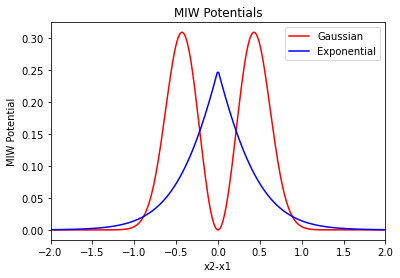

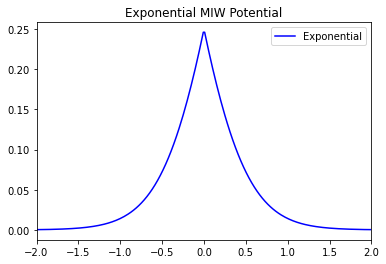

In [23]:
x1 = 0
start = -4
steps = 500
x2 = np.linspace(-start, start, steps)

b = .5

params = {
    "J":J,
    "D":D,
    "b":b,
    "ktype":"gaussian",
    "M":M,
}


X = np.zeros( ( 2 , 1 ) )

X[0][0] = x1
GaussianPotentials = np.zeros( (len(x2), 1) )
ExponentialPotentials = np.zeros( (len(x2), 1) )
for i in range(len(x2)):
    X[1][0] = x2[i]
    params["ktype"]="gaussian"
    F, U = MIW_Forces(X, params)
    GaussianPotentials[i] = U
    params["ktype"]="exponential"
    F, U = MIW_Forces(X, params)
    ExponentialPotentials[i] = U

plt.figure(1)
plt.title("MIW Potentials")
plt.xlabel("x2-x1")
plt.ylabel("MIW Potential")
plt.plot(x2, GaussianPotentials, color = 'red', label = 'Gaussian')
plt.plot(x2, ExponentialPotentials, color ='blue', label = 'Exponential')
plt.xlim ( (-2, 2) )
plt.legend()


plt.figure(2)
plt.title("Exponential MIW Potential")
plt.plot(x2, ExponentialPotentials, color = 'blue', label = 'Exponential')
#plt.ylim((0, max(ExponentialPotentials)))
plt.xlim( (-2, 2) )
plt.legend()

In [4]:
X = np.zeros((2, 2))
M = np.zeros((2, 2))
M+=1
X[0][0] = 0.0
X[0][1] = 0.2
X[1][0] = 0.2
X[1][1] = 0.4

print(X)
params = {
    "J":1,
    "D":2,
    "b":.1,
    "ktype":"gaussian",
    "M":M
}
print("inner", np.inner(X[1]-X[1], X[1]-X[1]))


MIW_Forces(X, params)

[[0.  0.2]
 [0.2 0.4]]
inner 0.0
Rsq[i][j] 0.08000000000000002
ddPik[1][1] =  -3175.6241868744464
Pij[0][1] 0.005339053545328193


(array([[ 2.65492069,  2.65492069],
        [-2.65492069, -2.65492069]]),
 8.99677680031071e-05)